<a href="https://colab.research.google.com/github/VinKKAP/Data-Analysis-with-LLM/blob/main/Experiment_Run1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [2]:
!git clone https://github.com/VinKKAP/Data-Analysis-with-LLM.git

Cloning into 'Data-Analysis-with-LLM'...
remote: Enumerating objects: 442, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 442 (delta 15), reused 51 (delta 7), pack-reused 375 (from 1)
Receiving objects: 100% (442/442), 58.12 MiB | 18.79 MiB/s, done.
Resolving deltas: 100% (199/199), done.
Updating files: 100% (94/94), done.


In [3]:
!pip install -r /content/Data-Analysis-with-LLM/experiment/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 109.2 MB/s eta 0:00:00

In [4]:
import torch
print(torch.cuda.is_available())

True


In [12]:
'''
Correlation Prediction Script
This script predicts correlations between column names using a DistilBERT model and Theil's U values.
The code is organized into several main sections:

1. Data Preprocessing
   - Loading and filtering data
   - Adding column type information
   - Labeling correlations (binary classification)

2. Train/Test Split Functions
   - Default split (def_split)
   - Dataset-aware split (ds_split)

3. Prediction Methods
   - Baseline using Jaccard similarity
   - DistilBERT model predictions

4. Evaluation and Metrics
   - Performance metrics calculation
   - Results logging
   - Wandb integration for experiment tracking

5. Main Pipeline
   - Data loading and preprocessing
   - Model training
   - Evaluation across different data subsets
'''

from multiprocessing import set_start_method
try:
    set_start_method('spawn')
except RuntimeError:
    pass

import sklearn.metrics as metrics
import pandas as pd
import random as rand
import time

from simpletransformers.classification import (
    ClassificationModel, ClassificationArgs
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from google.colab import drive
drive.mount('/content/drive')
from google.colab import userdata
userdata.get('HF_TOKEN')
import wandb
wandb.init(project="Distilbert_run20") # Initialize wandb run




# ---- Data Preprocessing Functions ----

def add_type(row):
    """ Enrich column name by adding column type.

    Args:
        row: describes correlation between two columns.

    Returns:
        row with enriched column names.
    """
    row['column1'] = row['column1'] + ' ' + row['type1']
    row['column2'] = row['column2'] + ' ' + row['type2']
    return row


# ---- Train/Test Split Functions ----

def def_split(data, test_ratio, seed):
    """ Split data into training and test set.

    With this approach, different column pairs from the
    same data set may appear in training and test set.

    Args:
        data: a pandas dataframe containing all data.
        test_ratio: ratio of test cases after split.
        seed: random seed for deterministic results.

    Returns:
        a tuple containing training, then test data.
    """
    print('Data sets in training and test may overlap')
    x_train, x_test, y_train, y_test = train_test_split(
      data[['column1', 'column2', 'type1', 'type2']], data['label'],
      test_size=test_ratio, random_state=seed)
    train = pd.concat([x_train, y_train], axis=1)
    test = pd.concat([x_test, y_test], axis=1)
    print(f'train shape: {train.shape}')
    print(f'test shape: {test.shape}')
    return train, test


def ds_split(data, test_ratio):
    """ Split column pairs into training and test samples.

    If only one dataset is present, this function will fall back
    to default train-test split.

    Args:
        data: a pandas dataframe containing all data.
        test_ratio: ratio of test cases after splitting.

    Returns:
        a tuple containing training, then test set.
    """
    # Check if multiple datasets are present
    unique_datasets = data['dataid'].nunique()

    if unique_datasets <= 1:
        print('Only one dataset detected. Falling back to default split.')
        # If only one dataset, use default train-test split
        return def_split(data, test_ratio, seed=42)

    print('Separating training and test sets by data')
    counts = data['dataid'].value_counts()
    nr_vals = len(counts)
    nr_test_ds = int(nr_vals * test_ratio)
    print(f'Nr. test data sets: {nr_test_ds}')

    ds_ids = counts.index.values.tolist()
    test_ds = rand.sample(ds_ids, nr_test_ds)
    print(f'TestDS: {test_ds}')

    def is_test(row):
        return row['dataid'] in test_ds

    data['istest'] = data.apply(is_test, axis=1)
    train = data[data['istest'] == False]
    test = data[data['istest'] == True]

    print(f'train.shape: {train.shape}')
    print(f'test.shape: {test.shape}')

    return train[
        ['column1', 'column2', 'type1', 'type2', 'label']], test[
            ['column1', 'column2', 'type1', 'type2', 'label']]


# ---- Prediction Methods ----

def baseline(col_pairs):
    """ A simple baseline predicting correlation via Jaccard similarity.

    Args:
        col_pairs: list of tuples with column names.

    Returns:
        list of predictions (1 for correlation, 0 for no correlation).
    """
    predictions = []
    for cp in col_pairs:
        c1 = cp[0]
        c2= cp[1]
        s1 = set(c1.split())
        s2 = set(c2.split())
        ns1 = len(s1)
        ns2 = len(s2)
        ni = len(set.intersection(s1, s2))
        # calculate Jaccard coefficient
        jac = ni / (ns1 + ns2 - ni)
        # predict correlation if similar
        if jac > 0.5:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


# ---- Evaluation and Metrics Functions ----

def log_metrics(
        coeff, min_v1, max_v2, mod_type, mod_name, scenario,
        test_ratio, sub_test, test_name, lb, ub, pred_method,
        out_path, training_time):
    """ Predicts using baseline or model, writes metrics to file.

    Args:
        (multiple arguments for logging performance metrics)
    """
    sub_test.columns = [
        'text_a', 'text_b', 'type1', 'type2', 'labels', 'length', 'nrtokens', 'prediction']
    # print out a sample for later analysis
    print(f'Sample for test {test_name}:')
    sample = sub_test.sample(frac=0.1)
    print(sample)
    # predict correlation via baseline or model
    sub_test = sub_test[['text_a', 'text_b', 'labels']]
    samples = []
    for _, r in sub_test.iterrows():
        samples.append([r['text_a'], r['text_b']])
    s_time = time.time()
    if pred_method == 0:
        preds = baseline(samples)
    else:
        preds = model.predict(samples)[0]
    # log various performance metrics
    t_time = time.time() - s_time
    nr_samples = len(sub_test.index)
    t_per_s = float(t_time) / nr_samples
    f1 = metrics.f1_score(sub_test['labels'], preds)
    pre = metrics.precision_score(sub_test['labels'], preds)
    rec = metrics.recall_score(sub_test['labels'], preds)
    acc = metrics.accuracy_score(sub_test['labels'], preds)
    mcc = metrics.matthews_corrcoef(sub_test['labels'], preds)
    # also log to local file
    with open(out_path, 'a+') as file:
        file.write(f'{coeff},{min_v1},{max_v2},"{mod_type}",' \
                f'"{mod_name}","{scenario}",{test_ratio},' \
                f'"{test_name}",{pred_method},{lb},{ub},' \
                f'{f1},{pre},{rec},{acc},{mcc},{t_per_s},' \
                f'{training_time}\n')
    # Log metrics to W&B
    wandb.log({
        "Coefficient": coeff,
        "F1 Score": f1,
        "Precision": pre,
        "Recall": rec,
        "Accuracy": acc,
        "MCC": mcc,
        "Prediction Time per Sample": t_per_s,
        "Training Time": training_time,
        "Test Name": test_name,
        "Test Ratio": test_ratio
    })

def names_length(row):
    """ Calculate combined length of column names. """
    return len(row['text_a']) + len(row['text_b'])


def names_tokens(row):
    """ Calculates number of tokens (separated by spaces). """
    return row['text_a'].count(' ') + row['text_b'].count(' ')


# ---- Main Pipeline Function ----

def run_correlation_prediction(
    src_path,
    coeff='theilsu',
    min_v1=0.15,
    max_v2=1,
    mod_type='distilbert',
    mod_name='distilbert-base-uncased',
    scenario='defsep',
    test_ratio=0.2,
    use_types=1,
    out_path='results.csv'
):
    # Initialize for deterministic results
    seed = 42
    rand.seed(seed)

    # Load and preprocess data
    data = pd.read_csv(src_path, sep=',')
    data = data.sample(frac=1, random_state=seed)

    # Rename columns to match expected format
    data.columns = [
        'dataid', 'datapath', 'nrrows', 'nrvals1', 'nrvals2',
        'type1', 'type2', 'column1', 'column2', 'method',
        'coefficient', 'pvalue', 'time', 'category1', 'category2'
    ]

    # Convert 'nan' strings to actual NaN values
    data['coefficient'] = pd.to_numeric(data['coefficient'], errors='coerce')
    data['pvalue'] = pd.to_numeric(data['pvalue'], errors='coerce')

    # Remove rows with NaN values
    data = data.dropna(subset=['coefficient', 'pvalue'])

    # Filter data for specific correlation method
    data = data[data['method']==coeff]
    nr_total = len(data.index)
    print(f'Nr. samples: {nr_total}')
    print('Sample from filtered data:')
    print(data.head())

    # Label data
    def coefficient_label(row):
        """ Label column pair as correlated or uncorrelated. """
        if abs(row['coefficient']) >= min_v1 and abs(row['pvalue']) <= max_v2:
            return 1
        else:
            return 0
    data['label'] = data.apply(coefficient_label, axis=1)


    # ---- Train/Test Split ----
    if scenario == 'defsep':
        train, test = def_split(data, test_ratio, seed)
    elif scenario == 'datasep':
        train, test = ds_split(data, test_ratio)
    else:
        raise ValueError(f'Undefined scenario: {scenario}')

    train.columns = ['text_a', 'text_b', 'type1', 'type2', 'labels']
    test.columns = ['text_a', 'text_b', 'type1', 'type2', 'labels']
    print(train.head())
    print(test.head())

    # ---- Model Training ----
    # Prepare loss scaling
    lab_counts = train['labels'].value_counts()
    nr_zeros = lab_counts.loc[0]
    nr_ones = lab_counts.loc[1]
    nr_all = float(len(train.index))
    weights = [nr_all/nr_zeros, nr_all/nr_ones]

    # Train classification model
    s_time = time.time()
    model_args = ClassificationArgs(
        num_train_epochs=5, train_batch_size=100, eval_batch_size=100,
        overwrite_output_dir=True, manual_seed=seed,
        evaluate_during_training=True, no_save=False,
        weight_decay=0.01,  # L2 regularization
        early_stopping_patience=3, # Early stopping
        )
    global model  # Make model global so it can be accessed in log_metrics
    model = ClassificationModel(
        mod_type, mod_name, weight=weights,
        use_cuda=True, args=model_args)
    model.train_model(
        train_df=train, eval_df=test, acc=metrics.accuracy_score,
        rec=metrics.recall_score, pre=metrics.precision_score,
        f1=metrics.f1_score)
    training_time = time.time() - s_time

    # ---- Evaluation ----
    test['length'] = test.apply(names_length, axis=1)
    test['nrtokens'] = test.apply(names_tokens, axis=1)

    # Initialize result file
    with open(out_path, 'w') as file:
        file.write(
            'coefficient,min_v1,max_v2,mod_type,mod_name,scenario,test_ratio,'
            'test_name,pred_method,lb,ub,f1,precision,recall,accuracy,mcc,'
            'prediction_time,training_time\n')

    # Use simple baseline and model for prediction
    for m in [0, 1]:
        # Get predictions based on model or baseline
        if m == 1:
            # Use model predictions
            predictions, raw_outputs = model.predict(test[['text_a', 'text_b']].values.tolist())
            test['prediction'] = predictions
        else:
            # Use baseline predictions
            test['prediction'] = 0  # Simple baseline predicts all as uncorrelated

        # Use entire test set
        test_name = f'{m}-final'
        log_metrics(
            coeff, min_v1, max_v2, mod_type, mod_name, scenario,
            test_ratio, test, test_name, 0, 'inf', m, out_path, training_time)

        # Test for data types
        for type1 in ['object', 'float64', 'int64', 'bool']:
            for type2 in ['object', 'float64', 'int64', 'bool']:
                sub_test = test.query(f'type1=="{type1}" and type2=="{type2}"')
                if sub_test.shape[0]:
                    test_name = f'Types{type1}-{type2}'
                    log_metrics(
                        coeff, min_v1, max_v2, mod_type, mod_name, scenario,
                        test_ratio, sub_test, test_name, -1, -1, m,
                        out_path, training_time)

        # Test for different subsets
        for q in [(0, 0.25), (0.25, 0.5), (0.5, 1)]:
            qlb = q[0]
            qub = q[1]
            # Column name length
            lb = test['length'].quantile(qlb)
            ub = test['length'].quantile(qub)
            sub_test = test[(test['length'] >= lb) & (test['length'] <= ub)]
            test_name = f'L{m}-{qlb}-{qub}'
            log_metrics(
                coeff, min_v1, max_v2, mod_type, mod_name, scenario,
                test_ratio, sub_test, test_name, lb, ub, m, out_path, training_time)

            # Number of tokens in column names
            lb = test['nrtokens'].quantile(qlb)
            ub = test['nrtokens'].quantile(qub)
            sub_test = test[(test['nrtokens'] >= lb) & (test['nrtokens'] <= ub)]
            test_name = f'N{m}-{qlb}-{qub}'
            log_metrics(
                coeff, min_v1, max_v2, mod_type, mod_name, scenario,
                test_ratio, sub_test, test_name, lb, ub, m, out_path, training_time)


# Example usage
if __name__ == '__main__':
    # Modify these parameters as needed
    run_correlation_prediction(
        src_path='/content/Data-Analysis-with-LLM/experiment/data/corresult6.csv',
        coeff='theilsu',
        min_v1=0.15,
        max_v2=1,
        mod_type='distilbert',
        mod_name='distilbert-base-uncased',
        scenario='defsep',
        test_ratio=0.2,
        use_types=1,
        out_path='/content/drive/My Drive/Colab Notebooks/Liter/correlations/results/results20.csv'
    )

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Nr. samples: 2556
Sample from filtered data:
      dataid                 datapath  nrrows  nrvals1  nrvals2   type1  \
1988       2  ../data/output_file.csv      63        6       21  object   
1216       2  ../data/output_file.csv      63        2        2  object   
1385       2  ../data/output_file.csv      63       38       22  object   
1334       2  ../data/output_file.csv      63       21        2  object   
175        2  ../data/output_file.csv      63        4        4  object   

       type2                       column1                  column2   method  \
1988  object      detailed_class_of_worker               birthplace  theilsu   
1216  object                   school_type  detailed_grade_attended  theilsu   
1385   int64  detailed_second_degree_field         year_of_marriage  theilsu   
1334  object           second_degree_field      married

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 3 of 5:   0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 4 of 5:   0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 5 of 5:   0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Sample for test 0-final:
                              text_a                          text_b    type1  \
1075              detailed_education                      white_race   object   
1450               employment_status             english_proficiency   object   
436              detailed_birthplace                household_weight   object   
2389                     wage_income              citizenship_status    int64   
2584            education_score_1990                      asian_race  float64   
1761  occupation_2010_classification  occupation_1990_classification   object   
2037                  soc_occupation                             sex   object   
1059              detailed_education                   detailed_race   object   
2233              usual_hours_worked                  fertility_year   object   
433              detailed_birthplace                     survey_year   object   
483                   first_ancestry                  fertility_year   object   
102

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

Sample for test Typesint64-object:
                text_a                   text_b  type1   type2  labels  \
194      year_of_birth         us_census_region  int64  object       1   
210      year_of_birth                      age  int64  object       1   
2408       wage_income  detailed_grade_attended  int64  object       0   
275   year_of_marriage      age_of_eldest_child  int64  object       1   
1641        occupation              school_type  int64  object       0   

      length  nrtokens  prediction  
194       29         0           0  
210       16         0           0  
2408      34         0           0  
275       35         0           0  
1641      21         0           0  
Sample for test Typesint64-float64:
Empty DataFrame
Columns: [text_a, text_b, type1, type2, labels, length, nrtokens, prediction]
Index: []
Sample for test Typesint64-int64:
                  text_a         text_b  type1  type2  labels  length  \
615  year_of_immigration  year_of_birth  int64  int

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

Sample for test N0-0.25-0.5:
                              text_a                          text_b    type1  \
890                       white_race                year_of_marriage   object   
1801                        industry                            race    int64   
1713  occupation_2010_classification                   person_weight   object   
315                             race  person_number_within_household   object   
1658  occupation_1990_classification                     family_size   object   
1215                     school_type                  grade_attended   object   
2108                  naics_industry                   detailed_race   object   
272                 year_of_marriage                     family_size    int64   
1864    industry_1990_classification                  fertility_year   object   
2564            education_score_1990                year_of_marriage  float64   
1617                      occupation                      birthplace    int64   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Sample for test 1-final:
                              text_a                          text_b    type1  \
1859    industry_1990_classification                  marital_status   object   
2116                  naics_industry          year_of_naturalization   object   
2161                    weeks_worked              number_of_siblings   object   
2565            education_score_1990                  fertility_year  float64   
1043              detailed_education                   person_weight   object   
910                       other_race                  dataset_number   object   
532               citizenship_status             age_of_eldest_child   object   
414                       birthplace                   person_weight   object   
65                       family_size                     survey_year   object   
2599            education_score_1990               employment_status  float64   
2612            education_score_1990        detailed_class_of_worker  float64   
735

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Sample for test Typesobject-object:
                              text_a                        text_b   type1  \
735             american_indian_race                           age  object   
2176                    weeks_worked                first_ancestry  object   
450              detailed_birthplace                marital_status  object   
2081                  soc_occupation  industry_1990_classification  object   
1229                    degree_field           age_of_eldest_child  object   
743             american_indian_race                 detailed_race  object   
2316                worked_last_year                    white_race  object   
1888    industry_1990_classification       detailed_grade_attended  object   
815                       black_race                          race  object   
2135                  naics_industry  detailed_second_degree_field  object   
1023                       education            citizenship_status  object   
1420               employmen

0it [00:00, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Sample for test Typesobject-float64:
               text_a                   text_b   type1    type2  labels  \
414        birthplace            person_weight  object  float64       1   
1904  class_of_worker         household_weight  object  float64       1   
1172      school_type  household_serial_number  object  float64       1   
358   hispanic_origin         household_weight  object  float64       1   

      length  nrtokens  prediction  
414       23         0           1  
1904      31         0           1  
1172      34         0           1  
358       31         0           1  


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sample for test Typesobject-int64:
                              text_a                          text_b   type1  \
1422               employment_status  person_number_within_household  object   
407                       birthplace                  dataset_number  object   
1191                     school_type                year_of_marriage  object   
1382    detailed_second_degree_field                   year_of_birth  object   
719             american_indian_race                     survey_year  object   
1760  occupation_2010_classification                      occupation  object   

      type2  labels  length  nrtokens  prediction  
1422  int64       0      47         0           0  
407   int64       0      24         0           0  
1191  int64       1      27         0           1  
1382  int64       1      41         0           1  
719   int64       0      31         0           0  
1760  int64       1      40         0           1  


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sample for test Typesfloat64-object:
                    text_a                        text_b    type1   type2  \
2572  education_score_1990                first_ancestry  float64  object   
2505       parent_presence             employment_status  float64  object   
2610  education_score_1990  industry_1990_classification  float64  object   

      labels  length  nrtokens  prediction  
2572       1      34         0           1  
2505       0      32         0           0  
2610       1      48         0           1  


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sample for test Typesfloat64-int64:
                    text_a        text_b    type1  type2  labels  length  \
2581  education_score_1990  years_in_usa  float64  int64       1      32   

      nrtokens  prediction  
2581         0           1  


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sample for test Typesint64-object:
                              text_a               text_b  type1   type2  \
45    person_number_within_household  metropolitan_status  int64  object   
208                    year_of_birth   number_of_siblings  int64  object   
1784                        industry   number_of_children  int64  object   
672                     years_in_usa        detailed_race  int64  object   
611              year_of_immigration                  age  int64  object   

      labels  length  nrtokens  prediction  
45         0      49         0           1  
208        0      31         0           0  
1784       1      26         0           1  
672        1      25         0           1  
611        1      22         0           1  


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sample for test Typesint64-float64:
Empty DataFrame
Columns: [text_a, text_b, type1, type2, labels, length, nrtokens, prediction]
Index: []


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sample for test Typesint64-int64:
            text_a          text_b  type1  type2  labels  length  nrtokens  \
187  year_of_birth  dataset_number  int64  int64       0      27         0   

     prediction  
187           0  


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sample for test L1-0-0.25:
                    text_a           text_b   type1   type2  labels  length  \
1260          degree_field        education  object  object       0      21   
1246          degree_field   first_ancestry  object  object       1      26   
2374           wage_income    year_of_birth   int64   int64       1      24   
2387           wage_income   first_ancestry   int64  object       1      25   
1785              industry  child_age_leq_4   int64  object       0      23   
735   american_indian_race              age  object  object       1      23   
891             white_race   fertility_year  object  object       0      24   
309                   race   dataset_number  object   int64       0      18   
1603            occupation   marital_status   int64  object       1      24   
1910       class_of_worker      family_size  object  object       1      26   
884             white_race              sex  object  object       0      13   
2069        soc_occupatio

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Sample for test N1-0-0.25:
                              text_a                        text_b    type1  \
2132                  naics_industry                  degree_field   object   
2600            education_score_1990    detailed_employment_status  float64   
2719         detailed_veteran_status               hispanic_origin   object   
616              year_of_immigration           number_of_marriages    int64   
45    person_number_within_household           metropolitan_status    int64   
1265           detailed_degree_field                   survey_year   object   
1569      labour_force_participation         detailed_degree_field   object   
2611            education_score_1990               class_of_worker  float64   
785                       asian_race       detailed_first_ancestry   object   
1206                     school_type          american_indian_race   object   
1702  occupation_1990_classification    detailed_employment_status   object   
1027                     

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Sample for test L1-0.25-0.5:
                    text_a               text_b    type1    type2  labels  \
305         fertility_year  number_of_marriages   object   object       0   
2653        veteran_status       first_ancestry   object   object       1   
1103        grade_attended        detailed_race   object   object       1   
1087        grade_attended        person_weight   object  float64       1   
1598            occupation  age_of_eldest_child    int64   object       1   
2594  education_score_1990          school_type  float64   object       0   
2067        soc_occupation       grade_attended   object   object       0   
991      school_attendance           other_race   object   object       1   
2041        soc_occupation  number_of_marriages   object   object       0   
304         fertility_year        year_of_birth   object    int64       1   
666           years_in_usa  married_within_year    int64   object       0   
615    year_of_immigration        year_of_birth

0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Sample for test N1-0.25-0.5:
                              text_a                          text_b    type1  \
991                school_attendance                      other_race   object   
719             american_indian_race                     survey_year   object   
1375    detailed_second_degree_field                 child_age_leq_4   object   
664                     years_in_usa                   year_of_birth    int64   
911                       other_race         household_serial_number   object   
2211              usual_hours_worked                     survey_year   object   
470                   first_ancestry                     family_size   object   
494          detailed_first_ancestry                us_census_region   object   
2306                worked_last_year         detailed_first_ancestry   object   
304                   fertility_year                   year_of_birth   object   
988                school_attendance                      black_race   object   

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Sample for test L1-0.5-1:
                              text_a                          text_b    type1  \
609              year_of_immigration              number_of_siblings    int64   
2307                worked_last_year              citizenship_status   object   
2011        detailed_class_of_worker             second_degree_field   object   
2611            education_score_1990                 class_of_worker  float64   
1126         detailed_grade_attended         household_serial_number   object   
560           year_of_naturalization                     family_size   object   
1879    industry_1990_classification                      asian_race   object   
2079                  soc_occupation  occupation_2010_classification   object   
480                   first_ancestry             number_of_marriages   object   
2502                 parent_presence           detailed_degree_field  float64   
362                  hispanic_origin  person_number_within_household   object   
18

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Sample for test N1-0.5-1:
                              text_a                        text_b    type1  \
2219              usual_hours_worked                 person_weight   object   
1688  occupation_1990_classification         pacific_islander_race   object   
894                       white_race               hispanic_origin   object   
1029                       education                    asian_race   object   
275                 year_of_marriage           age_of_eldest_child    int64   
884                       white_race                           sex   object   
1786                        industry           age_of_eldest_child    int64   
1488      detailed_employment_status              year_of_marriage   object   
455              detailed_birthplace                fertility_year   object   
452              detailed_birthplace           number_of_marriages   object   
2745         detailed_veteran_status  detailed_second_degree_field   object   
436              detailed_

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [19]:
'''
Correlation Prediction Script
This script predicts correlations between column names using a DistilBERT model and Theil's U values.
The code is organized into several main sections:

1. Data Preprocessing
   - Loading and filtering data
   - Adding column type information
   - Labeling correlations (binary classification)

2. Train/Test Split Functions
   - Default split (def_split)
   - Dataset-aware split (ds_split)

3. Prediction Methods
   - Baseline using Jaccard similarity
   - DistilBERT model predictions

4. Evaluation and Metrics
   - Performance metrics calculation
   - Results logging
   - Wandb integration for experiment tracking

5. Main Pipeline
   - Data loading and preprocessing
   - Model training
   - Evaluation across different data subsets
'''

from multiprocessing import set_start_method
try:
    set_start_method('spawn')
except RuntimeError:
    pass

import sklearn.metrics as metrics
import pandas as pd
import random as rand
import time

from simpletransformers.classification import (
    ClassificationModel, ClassificationArgs
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

from google.colab import drive
drive.mount('/content/drive')
from google.colab import userdata
userdata.get('HF_TOKEN')
import wandb
wandb.init(project="Distilbert_run26") # Initialize wandb run




# ---- Data Preprocessing Functions ----

def add_type(row):
    """ Enrich column name by adding column type.

    Args:
        row: describes correlation between two columns.

    Returns:
        row with enriched column names.
    """
    row['column1'] = row['column1'] + ' ' + row['type1']
    row['column2'] = row['column2'] + ' ' + row['type2']
    return row


# ---- Train/Test Split Functions ----

def def_split(data, test_ratio, seed):
    """ Split data into training and test set.

    With this approach, different column pairs from the
    same data set may appear in training and test set.

    Args:
        data: a pandas dataframe containing all data.
        test_ratio: ratio of test cases after split.
        seed: random seed for deterministic results.

    Returns:
        a tuple containing training, then test data.
    """
    print('Data sets in training and test may overlap')
    x_train, x_test, y_train, y_test = train_test_split(
      data[['column1', 'column2', 'type1', 'type2', 'category1', 'category2']], data['label'],
      test_size=test_ratio, random_state=seed)
    train = pd.concat([x_train, y_train], axis=1)
    test = pd.concat([x_test, y_test], axis=1)
    print(f'train shape: {train.shape}')
    print(f'test shape: {test.shape}')
    return train, test


def ds_split(data, test_ratio):
    """ Split column pairs into training and test samples.

    If only one dataset is present, this function will fall back
    to default train-test split.

    Args:
        data: a pandas dataframe containing all data.
        test_ratio: ratio of test cases after splitting.

    Returns:
        a tuple containing training, then test set.
    """
    # Check if multiple datasets are present
    unique_datasets = data['dataid'].nunique()

    if unique_datasets <= 1:
        print('Only one dataset detected. Falling back to default split.')
        # If only one dataset, use default train-test split
        return def_split(data, test_ratio, seed=42)

    print('Separating training and test sets by data')
    counts = data['dataid'].value_counts()
    nr_vals = len(counts)
    nr_test_ds = int(nr_vals * test_ratio)
    print(f'Nr. test data sets: {nr_test_ds}')

    ds_ids = counts.index.values.tolist()
    test_ds = rand.sample(ds_ids, nr_test_ds)
    print(f'TestDS: {test_ds}')

    def is_test(row):
        return row['dataid'] in test_ds

    data['istest'] = data.apply(is_test, axis=1)
    train = data[data['istest'] == False]
    test = data[data['istest'] == True]

    print(f'train.shape: {train.shape}')
    print(f'test.shape: {test.shape}')

    return train[
        ['column1', 'column2', 'type1', 'type2', 'label', 'category1', 'category2']], test[
            ['column1', 'column2', 'type1', 'type2', 'label', 'category1', 'category2']]


# ---- Prediction Methods ----

def baseline(col_pairs):
    """ A simple baseline predicting correlation via Jaccard similarity.

    Args:
        col_pairs: list of tuples with column names.

    Returns:
        list of predictions (1 for correlation, 0 for no correlation).
    """
    predictions = []
    for cp in col_pairs:
        c1 = cp[0]
        c2= cp[1]
        s1 = set(c1.split())
        s2 = set(c2.split())
        ns1 = len(s1)
        ns2 = len(s2)
        ni = len(set.intersection(s1, s2))
        # calculate Jaccard coefficient
        jac = ni / (ns1 + ns2 - ni)
        # predict correlation if similar
        if jac > 0.5:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


# ---- Evaluation and Metrics Functions ----

def log_metrics(
        coeff, min_v1, max_v2, mod_type, mod_name, scenario,
        test_ratio, sub_test, test_name, lb, ub, pred_method,
        out_path, training_time):
    """ Predicts using baseline or model, writes metrics to file.

    Args:
        (multiple arguments for logging performance metrics)
    """
    sub_test.columns = [
         'text_a', 'text_b', 'type1', 'type2', 'category1', 'category2', 'labels', 'length', 'nrtokens', 'prediction']
    # print out a sample for later analysis
    print(f'Sample for test {test_name}:')
    sample = sub_test.sample(frac=0.1)
    print(sample)
    # predict correlation via baseline or model
    sub_test = sub_test[['text_a', 'text_b', 'labels']]
    samples = []
    for _, r in sub_test.iterrows():
        samples.append([r['text_a'], r['text_b']])
    s_time = time.time()
    if pred_method == 0:
        preds = baseline(samples)
    else:
        preds = model.predict(samples)[0]
    # log various performance metrics
    t_time = time.time() - s_time
    nr_samples = len(sub_test.index)
    t_per_s = float(t_time) / nr_samples
    f1 = metrics.f1_score(sub_test['labels'], preds)
    pre = metrics.precision_score(sub_test['labels'], preds)
    rec = metrics.recall_score(sub_test['labels'], preds)
    acc = metrics.accuracy_score(sub_test['labels'], preds)
    mcc = metrics.matthews_corrcoef(sub_test['labels'], preds)
    # also log to local file
    with open(out_path, 'a+') as file:
        file.write(f'{coeff},{min_v1},{max_v2},"{mod_type}",' \
                f'"{mod_name}","{scenario}",{test_ratio},' \
                f'"{test_name}",{pred_method},{lb},{ub},' \
                f'{f1},{pre},{rec},{acc},{mcc},{t_per_s},' \
                f'{training_time}\n')
    # Log metrics to W&B
    wandb.log({
        "Coefficient": coeff,
        "F1 Score": f1,
        "Precision": pre,
        "Recall": rec,
        "Accuracy": acc,
        "MCC": mcc,
        "Prediction Time per Sample": t_per_s,
        "Training Time": training_time,
        "Test Name": test_name,
        "Test Ratio": test_ratio
    })

def names_length(row):
    """ Calculate combined length of column names. """
    return len(row['text_a']) + len(row['text_b'])


def names_tokens(row):
    """ Calculates number of tokens (separated by spaces). """
    return row['text_a'].count(' ') + row['text_b'].count(' ')


# ---- Main Pipeline Function ----

def run_correlation_prediction(
    src_path,
    coeff='theilsu',
    min_v1=0.3,
    max_v2=1,
    mod_type='distilbert',
    mod_name='distilbert-base-uncased',
    scenario='defsep',
    test_ratio=0.2,
    use_types=1,
    out_path='results.csv'
):
    # Initialize for deterministic results
    seed = 42
    rand.seed(seed)

    # Load and preprocess data
    data = pd.read_csv(src_path, sep=',')
    data = data.sample(frac=1, random_state=seed)

    # Rename columns to match expected format
    data.columns = [
        'dataid', 'datapath', 'nrrows', 'nrvals1', 'nrvals2',
        'type1', 'type2', 'column1', 'column2', 'method',
        'coefficient', 'pvalue', 'time', 'category1', 'category2'
    ]

    # Convert 'nan' strings to actual NaN values
    data['coefficient'] = pd.to_numeric(data['coefficient'], errors='coerce')
    data['pvalue'] = pd.to_numeric(data['pvalue'], errors='coerce')

    # Remove rows with NaN values
    data = data.dropna(subset=['coefficient', 'pvalue'])

    # Filter data for specific correlation method
    data = data[data['method']==coeff]
    nr_total = len(data.index)
    print(f'Nr. samples: {nr_total}')
    print('Sample from filtered data:')
    print(data.head())

    # Label data
    def coefficient_label(row):
        """ Label column pair as correlated or uncorrelated. """
        if abs(row['coefficient']) >= min_v1 and abs(row['pvalue']) <= max_v2:
            return 1
        else:
            return 0
    data['label'] = data.apply(coefficient_label, axis=1)


    # ---- Train/Test Split ----
    if scenario == 'defsep':
        train, test = def_split(data, test_ratio, seed)
    elif scenario == 'datasep':
        train, test = ds_split(data, test_ratio)
    else:
        raise ValueError(f'Undefined scenario: {scenario}')

    train.columns = ['text_a', 'text_b', 'type1', 'type2', 'category1', 'category2', 'labels']
    test.columns = ['text_a', 'text_b', 'type1', 'type2', 'category1', 'category2', 'labels']
    print(train.head())
    print(test.head())

    # ---- Model Training ----
    # Prepare loss scaling
    lab_counts = train['labels'].value_counts()
    nr_zeros = lab_counts.loc[0]
    nr_ones = lab_counts.loc[1]
    nr_all = float(len(train.index))
    weights = [nr_all/nr_zeros, nr_all/nr_ones]

    # Train classification model
    s_time = time.time()
    model_args = ClassificationArgs(
        num_train_epochs=5,
        train_batch_size=32,
        eval_batch_size=32,
        overwrite_output_dir=True,
        manual_seed=seed,
        evaluate_during_training=True,
        no_save=False,
        weight_decay=0.01,            # L2 regularization
        early_stopping_patience=5,     # Early stopping
        learning_rate=2e-5,           # kleinere Learning Rate
        warmup_steps=100,
        max_grad_norm=1.0,            # verhindert exploding gradients
        )
    global model  # Make model global so it can be accessed in log_metrics
    model = ClassificationModel(
        mod_type, mod_name, weight=weights,
        use_cuda=True, args=model_args)
    model.train_model(
        train_df=train, eval_df=test, acc=metrics.accuracy_score,
        rec=metrics.recall_score, pre=metrics.precision_score,
        f1=metrics.f1_score)
    training_time = time.time() - s_time

    # ---- Evaluation ----
    test['length'] = test.apply(names_length, axis=1)
    test['nrtokens'] = test.apply(names_tokens, axis=1)

    # Initialize result file
    with open(out_path, 'w') as file:
        file.write(
            'coefficient,min_v1,max_v2,mod_type,mod_name,scenario,test_ratio,'
            'test_name,pred_method,lb,ub,f1,precision,recall,accuracy,mcc,'
            'prediction_time,training_time\n')

    # Use simple baseline and model for prediction
    for m in [0, 1]:
        # Get predictions based on model or baseline
        if m == 1:
            # Use model predictions
            predictions, raw_outputs = model.predict(test[['text_a', 'text_b']].values.tolist())
            test['prediction'] = predictions
        else:
            # Use baseline predictions
            test['prediction'] = 0  # Simple baseline predicts all as uncorrelated

        # Use entire test set
        test_name = f'{m}-final'
        log_metrics(
            coeff, min_v1, max_v2, mod_type, mod_name, scenario,
            test_ratio, test, test_name, 0, 'inf', m, out_path, training_time)

        # Test for data types
        for type1 in ['object', 'float64', 'int64', 'bool']:
            for type2 in ['object', 'float64', 'int64', 'bool']:
                sub_test = test.query(f'type1=="{type1}" and type2=="{type2}"')
                if sub_test.shape[0]:
                    test_name = f'Types{type1}-{type2}'
                    log_metrics(
                        coeff, min_v1, max_v2, mod_type, mod_name, scenario,
                        test_ratio, sub_test, test_name, -1, -1, m,
                        out_path, training_time)

        # Test for different subsets
        for q in [(0, 0.25), (0.25, 0.5), (0.5, 1)]:
            qlb = q[0]
            qub = q[1]
            # Column name length
            lb = test['length'].quantile(qlb)
            ub = test['length'].quantile(qub)
            sub_test = test[(test['length'] >= lb) & (test['length'] <= ub)]
            test_name = f'L{m}-{qlb}-{qub}'
            log_metrics(
                coeff, min_v1, max_v2, mod_type, mod_name, scenario,
                test_ratio, sub_test, test_name, lb, ub, m, out_path, training_time)

            # Number of tokens in column names
            lb = test['nrtokens'].quantile(qlb)
            ub = test['nrtokens'].quantile(qub)
            sub_test = test[(test['nrtokens'] >= lb) & (test['nrtokens'] <= ub)]
            test_name = f'N{m}-{qlb}-{qub}'
            log_metrics(
                coeff, min_v1, max_v2, mod_type, mod_name, scenario,
                test_ratio, sub_test, test_name, lb, ub, m, out_path, training_time)

    # Evaluate demographic performance
    evaluate_demographic_performance(test, model, out_path, training_time,
                                  coeff=coeff, min_v1=min_v1, max_v2=max_v2,
                                  mod_type=mod_type, mod_name=mod_name,
                                  test_ratio=test_ratio)

def evaluate_demographic_performance(test_df, model, out_path, training_time, **params):
    """Evaluate model performance specifically for demographic data."""
    demographic_out_path = '/content/drive/My Drive/Colab Notebooks/Liter/correlations/results/demographic.csv'

    # Filter for demographic data
    demographic_test = test_df[
        (test_df['category1'] == 'Demographic') |
        (test_df['category2'] == 'Demographic')
    ]

    if len(demographic_test) == 0:
        print("No demographic data found in test set")
        return

    # Print analysis of demographic data distribution
    print("\nDemographic Data Analysis:")
    print(f"Total demographic pairs: {len(demographic_test)}")
    print(f"Positive correlations: {sum(demographic_test['labels'])}")
    print(f"Negative correlations: {len(demographic_test) - sum(demographic_test['labels'])}")

    # Get predictions
    samples = demographic_test[['text_a', 'text_b']].values.tolist()
    predictions = model.predict(samples)[0]

    # Create DataFrame with predictions for detailed analysis
    results_df = demographic_test.copy()
    results_df['predicted'] = predictions

    # Detailed Confusion Matrix Analysis
    print("\nDetailed Confusion Matrix Analysis:")

    print("\n1. True Positives (Correctly predicted correlations):")
    true_positives = results_df[(results_df['labels'] == 1) & (results_df['predicted'] == 1)]
    print(f"Count: {len(true_positives)}")
    for _, row in true_positives.iterrows():
        print(f"\nColumn 1: {row['text_a']}")
        print(f"Column 2: {row['text_b']}")

    print("\n2. False Positives (Incorrectly predicted as correlated):")
    false_positives = results_df[(results_df['labels'] == 0) & (results_df['predicted'] == 1)]
    print(f"Count: {len(false_positives)}")
    for _, row in false_positives.iterrows():
        print(f"\nColumn 1: {row['text_a']}")
        print(f"Column 2: {row['text_b']}")

    print("\n3. False Negatives (Missed correlations):")
    false_negatives = results_df[(results_df['labels'] == 1) & (results_df['predicted'] == 0)]
    print(f"Count: {len(false_negatives)}")
    for _, row in false_negatives.iterrows():
        print(f"\nColumn 1: {row['text_a']}")
        print(f"Column 2: {row['text_b']}")

    # Calculate basic metrics
    f1 = metrics.f1_score(demographic_test['labels'], predictions)
    pre = metrics.precision_score(demographic_test['labels'], predictions)
    rec = metrics.recall_score(demographic_test['labels'], predictions)
    acc = metrics.accuracy_score(demographic_test['labels'], predictions)
    mcc = metrics.matthews_corrcoef(demographic_test['labels'], predictions)

    # Calculate confusion matrix
    cm = confusion_matrix(demographic_test['labels'], predictions)

    # Analyze demographic pair types
    demo_pairs = pd.DataFrame({
        'pair_type': demographic_test.apply(
            lambda x: 'Demo-Demo' if x['category1'] == 'Demographic'
            and x['category2'] == 'Demographic' else 'Demo-Other', axis=1
        )
    })
    pair_type_stats = demo_pairs['pair_type'].value_counts()

    # Log to wandb with enhanced metrics
    wandb.log({
        "Demographic_F1": f1,
        "Demographic_Precision": pre,
        "Demographic_Recall": rec,
        "Demographic_Accuracy": acc,
        "Demographic_MCC": mcc,
        "Demographic_Pair_Distribution": pair_type_stats.to_dict(),
        "Demographic_Confusion_Matrix": wandb.plot.confusion_matrix(
            probs=None,
            y_true=demographic_test['labels'].tolist(),
            preds=predictions.tolist(),
            class_names=["Not Correlated", "Correlated"]
        )
    })

    # Log to demographic file
    try:
        with open(demographic_out_path, 'a+') as file:
            # Wenn die Datei neu ist, schreibe Header
            if file.tell() == 0:
                file.write('coefficient,min_v1,max_v2,mod_type,mod_name,scenario,'
                          'test_ratio,test_name,pred_method,lb,ub,f1,precision,'
                          'recall,accuracy,mcc,prediction_time,training_time,'
                          'demo_demo_pairs,demo_other_pairs\n')

            file.write(f'{params["coeff"]},{params["min_v1"]},{params["max_v2"]},'
                      f'"{params["mod_type"]}","{params["mod_name"]}","demographic",'
                      f'{params["test_ratio"]},"demographic_eval",1,-1,-1,'
                      f'{f1},{pre},{rec},{acc},{mcc},-1,{training_time},'
                      f'{pair_type_stats.get("Demo-Demo", 0)},'
                      f'{pair_type_stats.get("Demo-Other", 0)}\n')
    except IOError as e:
        print(f"Fehler beim Schreiben der Datei: {e}")
        print("Bitte stellen Sie sicher, dass Google Drive gemounted ist und Sie Schreibrechte haben.")

    print(f"\nDemographic evaluation results saved to: {demographic_out_path}")
    print(f"Confusion Matrix:")
    print(cm)
    print(f"\nPair Type Distribution:")
    print(pair_type_stats)


# Example usage
if __name__ == '__main__':
    # Modify these parameters as needed
    run_correlation_prediction(
        src_path='/content/Data-Analysis-with-LLM/experiment/data/corresult6.csv',
        coeff='theilsu',
        min_v1=0.3,
        max_v2=1,
        mod_type='distilbert',
        mod_name='distilbert-base-uncased',
        scenario='defsep',
        test_ratio=0.2,
        use_types=1,
        out_path='/content/drive/My Drive/Colab Notebooks/Liter/correlations/results/results26.csv'
    )

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Nr. samples: 2556
Sample from filtered data:
      dataid                 datapath  nrrows  nrvals1  nrvals2   type1  \
1988       2  ../data/output_file.csv      63        6       21  object   
1216       2  ../data/output_file.csv      63        2        2  object   
1385       2  ../data/output_file.csv      63       38       22  object   
1334       2  ../data/output_file.csv      63       21        2  object   
175        2  ../data/output_file.csv      63        4        4  object   

       type2                       column1                  column2   method  \
1988  object      detailed_class_of_worker               birthplace  theilsu   
1216  object                   school_type  detailed_grade_attended  theilsu   
1385   int64  detailed_second_degree_field         year_of_marriage  theilsu   
1334  object           second_degree_field      married

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 3 of 5:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 4 of 5:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 5 of 5:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Sample for test 0-final:
                              text_a                          text_b    type1  \
1075              detailed_education                      white_race   object   
1450               employment_status             english_proficiency   object   
436              detailed_birthplace                household_weight   object   
2389                     wage_income              citizenship_status    int64   
2584            education_score_1990                      asian_race  float64   
1761  occupation_2010_classification  occupation_1990_classification   object   
2037                  soc_occupation                             sex   object   
1059              detailed_education                   detailed_race   object   
2233              usual_hours_worked                  fertility_year   object   
433              detailed_birthplace                     survey_year   object   
483                   first_ancestry                  fertility_year   object   
102

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

Sample for test Typesfloat64-int64:
                    text_a            text_b    type1  type2  category1  \
2564  education_score_1990  year_of_marriage  float64  int64  Education   

                  category2  labels  length  nrtokens  prediction  
2564  Marital and Fertility       1      36         0           0  
Sample for test Typesint64-object:
                text_a                   text_b  type1   type2  \
194      year_of_birth         us_census_region  int64  object   
210      year_of_birth                      age  int64  object   
2408       wage_income  detailed_grade_attended  int64  object   
275   year_of_marriage      age_of_eldest_child  int64  object   
1641        occupation              school_type  int64  object   

                  category1    category2  labels  length  nrtokens  prediction  
194             Demographic    Household       1      29         0           0  
210             Demographic  Demographic       1      16         0           0  
24

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

Sample for test L0-0.25-0.5:
                            text_a                   text_b    type1   type2  \
827                     black_race      english_proficiency   object  object   
2473               parent_presence            detailed_race  float64  object   
513        detailed_first_ancestry                     race   object  object   
1455             employment_status               white_race   object  object   
975              school_attendance          hispanic_origin   object  object   
2189                  weeks_worked        school_attendance   object  object   
2375                   wage_income      number_of_marriages    int64  object   
1230                  degree_field    age_of_youngest_child   object  object   
785                     asian_race  detailed_first_ancestry   object  object   
1206                   school_type     american_indian_race   object  object   
1858  industry_1990_classification                      age   object  object   
2182       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Sample for test 1-final:
                              text_a                          text_b    type1  \
1859    industry_1990_classification                  marital_status   object   
2116                  naics_industry          year_of_naturalization   object   
2161                    weeks_worked              number_of_siblings   object   
2565            education_score_1990                  fertility_year  float64   
1043              detailed_education                   person_weight   object   
910                       other_race                  dataset_number   object   
532               citizenship_status             age_of_eldest_child   object   
414                       birthplace                   person_weight   object   
65                       family_size                     survey_year   object   
2599            education_score_1990               employment_status  float64   
2612            education_score_1990        detailed_class_of_worker  float64   
735

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Sample for test Typesobject-object:
                              text_a                        text_b   type1  \
735             american_indian_race                           age  object   
2176                    weeks_worked                first_ancestry  object   
450              detailed_birthplace                marital_status  object   
2081                  soc_occupation  industry_1990_classification  object   
1229                    degree_field           age_of_eldest_child  object   
743             american_indian_race                 detailed_race  object   
2316                worked_last_year                    white_race  object   
1888    industry_1990_classification       detailed_grade_attended  object   
815                       black_race                          race  object   
2135                  naics_industry  detailed_second_degree_field  object   
1023                       education            citizenship_status  object   
1420               employmen

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Sample for test Typesobject-float64:
               text_a                   text_b   type1    type2    category1  \
414        birthplace            person_weight  object  float64  Demographic   
1904  class_of_worker         household_weight  object  float64   Employment   
1172      school_type  household_serial_number  object  float64    Education   
358   hispanic_origin         household_weight  object  float64  Demographic   

            category2  labels  length  nrtokens  prediction  
414   Survey Metadata       1      23         0           1  
1904        Household       1      31         0           1  
1172  Survey Metadata       1      34         0           1  
358         Household       1      31         0           1  


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Sample for test Typesobject-int64:
                              text_a                          text_b   type1  \
1422               employment_status  person_number_within_household  object   
407                       birthplace                  dataset_number  object   
1191                     school_type                year_of_marriage  object   
1382    detailed_second_degree_field                   year_of_birth  object   
719             american_indian_race                     survey_year  object   
1760  occupation_2010_classification                      occupation  object   

      type2    category1              category2  labels  length  nrtokens  \
1422  int64   Employment        Survey Metadata       0      47         0   
407   int64  Demographic        Survey Metadata       0      24         0   
1191  int64    Education  Marital and Fertility       1      27         0   
1382  int64    Education            Demographic       1      41         0   
719   int64  Demogr

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Sample for test Typesfloat64-object:
                    text_a                        text_b    type1   type2  \
2572  education_score_1990                first_ancestry  float64  object   
2505       parent_presence             employment_status  float64  object   
2610  education_score_1990  industry_1990_classification  float64  object   

      category1    category2  labels  length  nrtokens  prediction  
2572  Education  Demographic       1      34         0           1  
2505  Household   Employment       0      32         0           0  
2610  Education   Employment       1      48         0           1  


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sample for test Typesfloat64-int64:
                    text_a        text_b    type1  type2  category1  \
2581  education_score_1990  years_in_usa  float64  int64  Education   

        category2  labels  length  nrtokens  prediction  
2581  Demographic       1      32         0           1  


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sample for test Typesint64-object:
                              text_a               text_b  type1   type2  \
45    person_number_within_household  metropolitan_status  int64  object   
208                    year_of_birth   number_of_siblings  int64  object   
1784                        industry   number_of_children  int64  object   
672                     years_in_usa        detailed_race  int64  object   
611              year_of_immigration                  age  int64  object   

            category1    category2  labels  length  nrtokens  prediction  
45    Survey Metadata    Household       0      49         0           0  
208       Demographic    Household       0      31         0           0  
1784       Employment    Household       0      26         0           0  
672       Demographic  Demographic       1      25         0           1  
611       Demographic  Demographic       1      22         0           1  


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Sample for test Typesint64-float64:
Empty DataFrame
Columns: [text_a, text_b, type1, type2, category1, category2, labels, length, nrtokens, prediction]
Index: []


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sample for test Typesint64-int64:
            text_a          text_b  type1  type2    category1  \
187  year_of_birth  dataset_number  int64  int64  Demographic   

           category2  labels  length  nrtokens  prediction  
187  Survey Metadata       0      27         0           0  


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sample for test L1-0-0.25:
                    text_a           text_b   type1   type2    category1  \
1260          degree_field        education  object  object    Education   
1246          degree_field   first_ancestry  object  object    Education   
2374           wage_income    year_of_birth   int64   int64   Employment   
2387           wage_income   first_ancestry   int64  object   Employment   
1785              industry  child_age_leq_4   int64  object   Employment   
735   american_indian_race              age  object  object  Demographic   
891             white_race   fertility_year  object  object  Demographic   
309                   race   dataset_number  object   int64  Demographic   
1603            occupation   marital_status   int64  object   Employment   
1910       class_of_worker      family_size  object  object   Employment   
884             white_race              sex  object  object  Demographic   
2069        soc_occupation      school_type  object  object  

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Sample for test N1-0-0.25:
                              text_a                        text_b    type1  \
2132                  naics_industry                  degree_field   object   
2600            education_score_1990    detailed_employment_status  float64   
2719         detailed_veteran_status               hispanic_origin   object   
616              year_of_immigration           number_of_marriages    int64   
45    person_number_within_household           metropolitan_status    int64   
1265           detailed_degree_field                   survey_year   object   
1569      labour_force_participation         detailed_degree_field   object   
2611            education_score_1990               class_of_worker  float64   
785                       asian_race       detailed_first_ancestry   object   
1206                     school_type          american_indian_race   object   
1702  occupation_1990_classification    detailed_employment_status   object   
1027                     

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Sample for test L1-0.25-0.5:
                    text_a               text_b    type1    type2  \
305         fertility_year  number_of_marriages   object   object   
2653        veteran_status       first_ancestry   object   object   
1103        grade_attended        detailed_race   object   object   
1087        grade_attended        person_weight   object  float64   
1598            occupation  age_of_eldest_child    int64   object   
2594  education_score_1990          school_type  float64   object   
2067        soc_occupation       grade_attended   object   object   
991      school_attendance           other_race   object   object   
2041        soc_occupation  number_of_marriages   object   object   
304         fertility_year        year_of_birth   object    int64   
666           years_in_usa  married_within_year    int64   object   
615    year_of_immigration        year_of_birth    int64    int64   
1786              industry  age_of_eldest_child    int64   object   
208  

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Sample for test N1-0.25-0.5:
                              text_a                          text_b    type1  \
991                school_attendance                      other_race   object   
719             american_indian_race                     survey_year   object   
1375    detailed_second_degree_field                 child_age_leq_4   object   
664                     years_in_usa                   year_of_birth    int64   
911                       other_race         household_serial_number   object   
2211              usual_hours_worked                     survey_year   object   
470                   first_ancestry                     family_size   object   
494          detailed_first_ancestry                us_census_region   object   
2306                worked_last_year         detailed_first_ancestry   object   
304                   fertility_year                   year_of_birth   object   
988                school_attendance                      black_race   object   

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Sample for test L1-0.5-1:
                              text_a                          text_b    type1  \
609              year_of_immigration              number_of_siblings    int64   
2307                worked_last_year              citizenship_status   object   
2011        detailed_class_of_worker             second_degree_field   object   
2611            education_score_1990                 class_of_worker  float64   
1126         detailed_grade_attended         household_serial_number   object   
560           year_of_naturalization                     family_size   object   
1879    industry_1990_classification                      asian_race   object   
2079                  soc_occupation  occupation_2010_classification   object   
480                   first_ancestry             number_of_marriages   object   
2502                 parent_presence           detailed_degree_field  float64   
362                  hispanic_origin  person_number_within_household   object   
18

0it [00:00, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Sample for test N1-0.5-1:
                              text_a                        text_b    type1  \
2219              usual_hours_worked                 person_weight   object   
1688  occupation_1990_classification         pacific_islander_race   object   
894                       white_race               hispanic_origin   object   
1029                       education                    asian_race   object   
275                 year_of_marriage           age_of_eldest_child    int64   
884                       white_race                           sex   object   
1786                        industry           age_of_eldest_child    int64   
1488      detailed_employment_status              year_of_marriage   object   
455              detailed_birthplace                fertility_year   object   
452              detailed_birthplace           number_of_marriages   object   
2745         detailed_veteran_status  detailed_second_degree_field   object   
436              detailed_

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():



Demographic Data Analysis:
Total demographic pairs: 266
Positive correlations: 136
Negative correlations: 130


0it [00:00, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():



Detailed Confusion Matrix Analysis:

1. True Positives (Correctly predicted correlations):
Count: 125

Column 1: occupation_1990_classification
Column 2: age

Column 1: naics_industry
Column 2: years_in_usa

Column 1: detailed_class_of_worker
Column 2: year_of_birth

Column 1: education_score_1990
Column 2: years_in_usa

Column 1: worked_last_year
Column 2: detailed_birthplace

Column 1: occupation
Column 2: birthplace

Column 1: school_attendance
Column 2: detailed_birthplace

Column 1: industry_1990_classification
Column 2: age

Column 1: english_proficiency
Column 2: year_of_immigration

Column 1: black_race
Column 2: person_weight

Column 1: years_in_usa
Column 2: detailed_race

Column 1: detailed_employment_status
Column 2: age

Column 1: hispanic_origin
Column 2: household_weight

Column 1: education
Column 2: year_of_birth

Column 1: detailed_employment_status
Column 2: birthplace

Column 1: american_indian_race
Column 2: household_weight

Column 1: asian_race
Column 2: househo

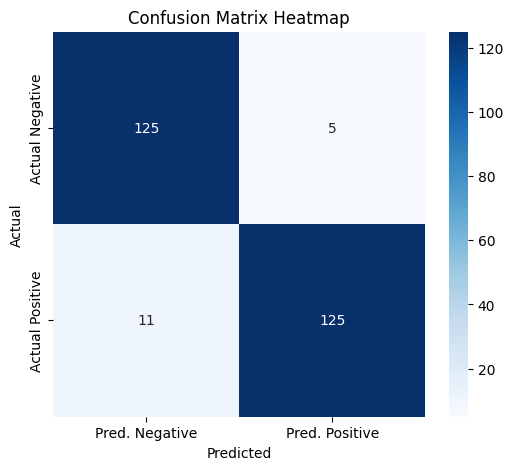

<ipython-input-1-6b306c215eba>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pair_type_data, x='Pair Type', y='Count', palette='muted')


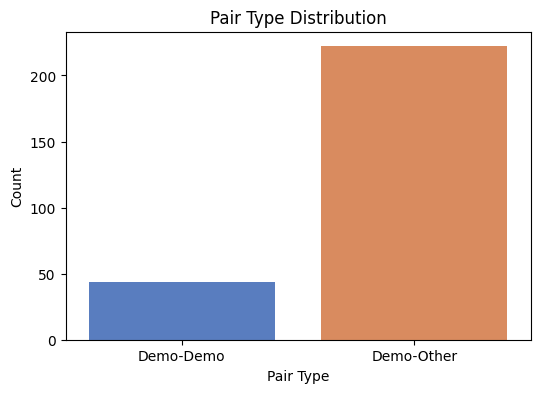

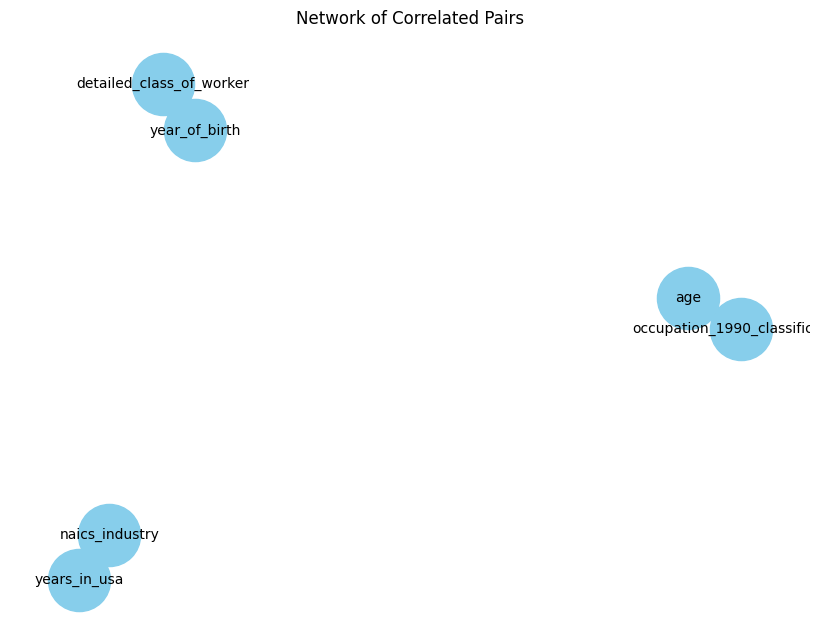

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx

# Simulated Data
conf_matrix = np.array([[125, 5], [11, 125]])
pair_type_data = pd.DataFrame({
    'Pair Type': ['Demo-Demo', 'Demo-Other'],
    'Count': [44, 222]
})
correlated_pairs = [
    ('age', 'occupation_1990_classification'),
    ('years_in_usa', 'naics_industry'),
    ('year_of_birth', 'detailed_class_of_worker')
]

# 1. Heatmap for Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred. Negative', 'Pred. Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 2. Pair Type Distribution (Bar Chart)
plt.figure(figsize=(6, 4))
sns.barplot(data=pair_type_data, x='Pair Type', y='Count', palette='muted')
plt.title("Pair Type Distribution")
plt.ylabel("Count")
plt.xlabel("Pair Type")
plt.show()

# 3. Network Graph for Correlated Pairs
G = nx.Graph()
G.add_edges_from(correlated_pairs)
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)  # For consistent layout
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=10, edge_color='gray')
plt.title("Network of Correlated Pairs")
plt.show()


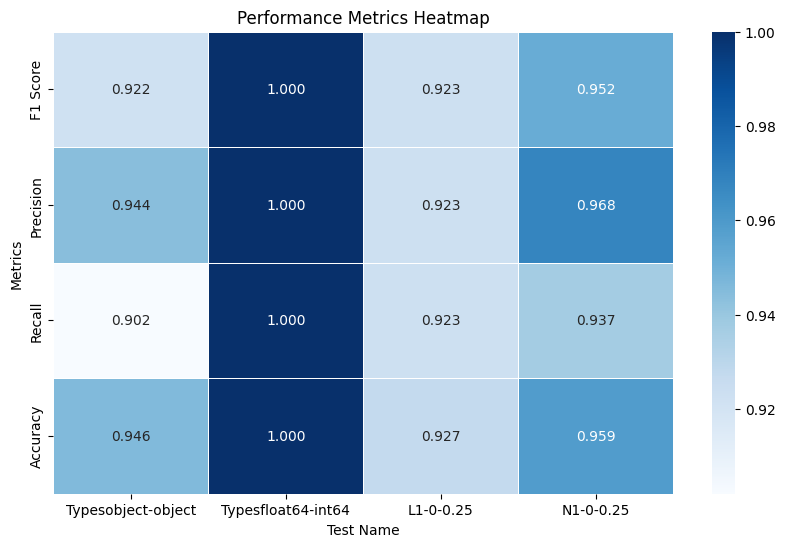

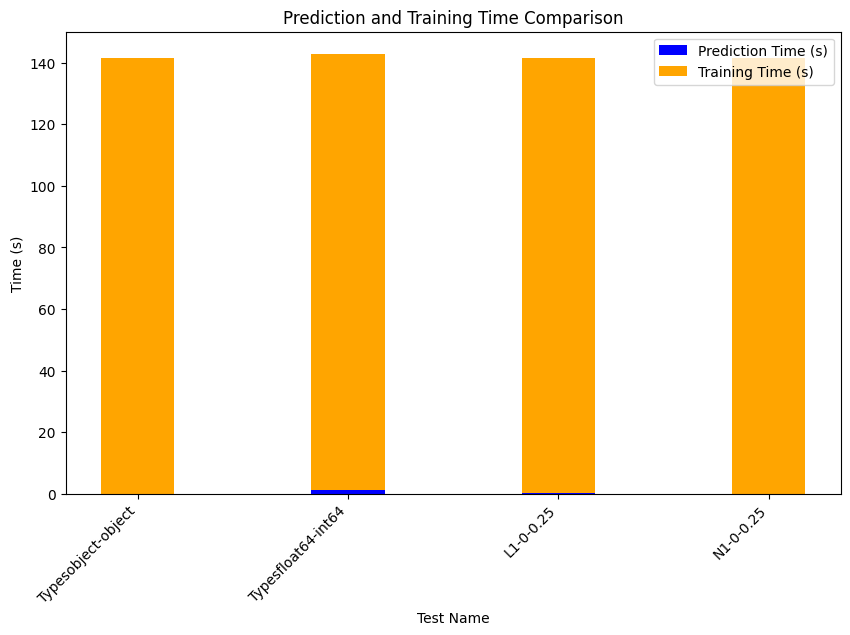

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Beispiel-Daten
data = {
    "Scenario": ["defsep", "defsep", "defsep", "defsep"],
    "Test Name": ["Typesobject-object", "Typesfloat64-int64", "L1-0-0.25", "N1-0-0.25"],
    "F1 Score": [0.922, 1.000, 0.923, 0.952],
    "Precision": [0.944, 1.000, 0.923, 0.968],
    "Recall": [0.902, 1.000, 0.923, 0.937],
    "Accuracy": [0.946, 1.000, 0.927, 0.959],
    "Prediction Time (s)": [0.031, 1.33, 0.073, 0.016],
    "Training Time (s)": [141.58, 141.58, 141.58, 141.58],
}

df = pd.DataFrame(data)

# Heatmap für Metriken
metrics = df[["F1 Score", "Precision", "Recall", "Accuracy"]]
heatmap_data = metrics.transpose()
heatmap_data.columns = df["Test Name"]

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="Blues", fmt=".3f", linewidths=0.5)
plt.title("Performance Metrics Heatmap")
plt.ylabel("Metrics")
plt.xlabel("Test Name")
plt.show()

# Balkendiagramm für Vorhersage- und Trainingszeit
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = df["Test Name"]
prediction_time = df["Prediction Time (s)"]
training_time = df["Training Time (s)"]

bar1 = plt.bar(index, prediction_time, bar_width, label="Prediction Time (s)", color="blue")
bar2 = plt.bar(index, training_time, bar_width, bottom=prediction_time, label="Training Time (s)", color="orange")

plt.xlabel("Test Name")
plt.ylabel("Time (s)")
plt.title("Prediction and Training Time Comparison")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.show()
